In [51]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
import math
from sklearn.linear_model import LogisticRegression
from scipy.special import expit
from datetime import datetime

In [52]:
task_3_4 = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2021-2022/eedi/task_3_4.csv.gz')
subject_metadata = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2021-2022/eedi/subject_metadata.csv.gz')
question_metadata_task_3_4 = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2021-2022/eedi/question_metadata_task_3_4.csv.gz')
answer_metadata_task_3_4 = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2021-2022/eedi/answer_metadata_task_3_4.csv.gz')
student_metadata_task_3_4 = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2021-2022/eedi/student_metadata_task_3_4.csv.gz')

In [53]:
confidence_response_df = pd.merge(task_3_4, answer_metadata_task_3_4, on = 'AnswerId')
confidence_response_df.drop(['UserId', 'QuestionId', 'AnswerValue', 'DateAnswered', 'GroupId', 'QuizId','SchemeOfWorkId', 'CorrectAnswer'], axis= 1, inplace = True)
confidence_response_df.dropna(subset = ['Confidence'], inplace = True)
X = confidence_response_df['Confidence'].values
y = confidence_response_df['IsCorrect'].values

Beta 0: -0.8385767012861604, Beta 1: 0.018403508301743737
0.6607346981190897


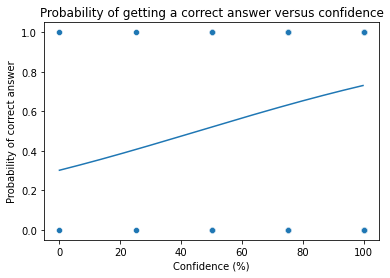

In [54]:
model = LogisticRegression().fit(X.reshape(-1, 1), y)
beta0 = model.intercept_[0]
beta1 = model.coef_[0][0]
print("Beta 0: " + str(beta0) + ", Beta 1: " + str(beta1))
plt.figure()

sns.scatterplot(x='Confidence', y='IsCorrect', data=confidence_response_df.sample(50))
x = np.arange(confidence_response_df.Confidence.min(), confidence_response_df.Confidence.max(), 0.25)
plt.plot(x, model.predict_proba(np.reshape(x, (-1, 1)))[:,1])
plt.xlabel("Confidence (%)")
plt.ylabel("Probability of correct answer")
plt.title("Probability of getting a correct answer versus confidence")
print(model.score(X.reshape(-1, 1), y))

In [55]:
confidence_0 = confidence_response_df[confidence_response_df['Confidence'] == 0]
confidence_0_correct = (len(confidence_0[confidence_0['IsCorrect'] == 1]))
confidence_0_ratio = confidence_0_correct / (len(confidence_0) - confidence_0_correct)
confidence_100 = confidence_response_df[confidence_response_df['Confidence'] == 100]
confidence_100_correct = (len(confidence_100[confidence_100['IsCorrect'] == 1]))
confidence_100_ratio = confidence_100_correct / (len(confidence_100) - confidence_100_correct)
print(confidence_0_ratio)
print(confidence_100_ratio)
odds_ratio = confidence_100_ratio / confidence_0_ratio
print(odds_ratio)

0.5030077941099544
2.7415593252152695
5.450331699265839


/tmp/ipykernel_33/17725046.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ratios = pd.Series()


0.8571428571428571
99


/tmp/ipykernel_33/17725046.py:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  overconfidentSubjects = pd.Series()
/tmp/ipykernel_33/17725046.py:31: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  level1 = pd.Series()
/tmp/ipykernel_33/17725046.py:32: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  level2 = pd.Series()
/tmp/ipykernel_33/17725046.py:33: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  level3 = pd.Series()


73771


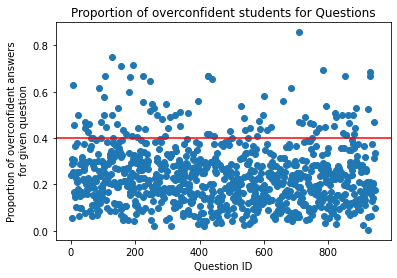

In [56]:
overconfident_underconfident = pd.merge(task_3_4, answer_metadata_task_3_4, on = 'AnswerId')
overconfident_underconfident = pd.merge(overconfident_underconfident, question_metadata_task_3_4, on = 'QuestionId')
overconfident_underconfident.drop(['DateAnswered', 'GroupId', 'QuizId', 'SchemeOfWorkId', 'UserId'], axis = 1, inplace = True)
overconfident_underconfident.dropna(subset = ['Confidence'], inplace = True)
overconfident = overconfident_underconfident[(overconfident_underconfident['Confidence'] >= 75) & (overconfident_underconfident['IsCorrect'] == 0)]
counts = overconfident['QuestionId'].value_counts()
ratios = pd.Series()
threshold = 0.4
for i in counts.index:
    ratios.at[i] = counts[i] / overconfident_underconfident['QuestionId'].value_counts()[i]
ratios.sort_values(ascending = False, inplace = True)
print(ratios.max())
plt.scatter(ratios.index, ratios.values)
plt.axhline(threshold, color='red')
plt.title("Proportion of overconfident students for Questions")
plt.xlabel("Question ID")
plt.ylabel("Proportion of overconfident answers\n for given question")
overconfidentQuestions = ratios[ratios >= threshold]
print(len(overconfidentQuestions))
overconfidentSubjects = pd.Series()
for i in overconfidentQuestions.index:
    overconfidentSubjects.at[i] = overconfident_underconfident.loc[overconfident_underconfident['QuestionId'] == i, 'SubjectId'].iloc[0]
for z in overconfidentSubjects.index:
    subjects = []
    li = overconfidentSubjects[z]
    li = li[1:-1]
    li = li.split(', ')
    for i in range(len(li)):
        subjects.append(subject_metadata.loc[subject_metadata['SubjectId'] == int(li[i]), 'Name'].iloc[0])
    overconfidentSubjects.at[z] = subjects
level1 = pd.Series()
level2 = pd.Series()
level3 = pd.Series()
for i in overconfidentSubjects.index:
    level1.at[i] = (overconfidentSubjects[i])[1]
    level2.at[i] = (overconfidentSubjects[i])[2]
    level3.at[i] = (overconfidentSubjects[i])[3]
    
overconfidentcount = len(overconfident)
print(overconfidentcount)

<BarContainer object of 35 artists>

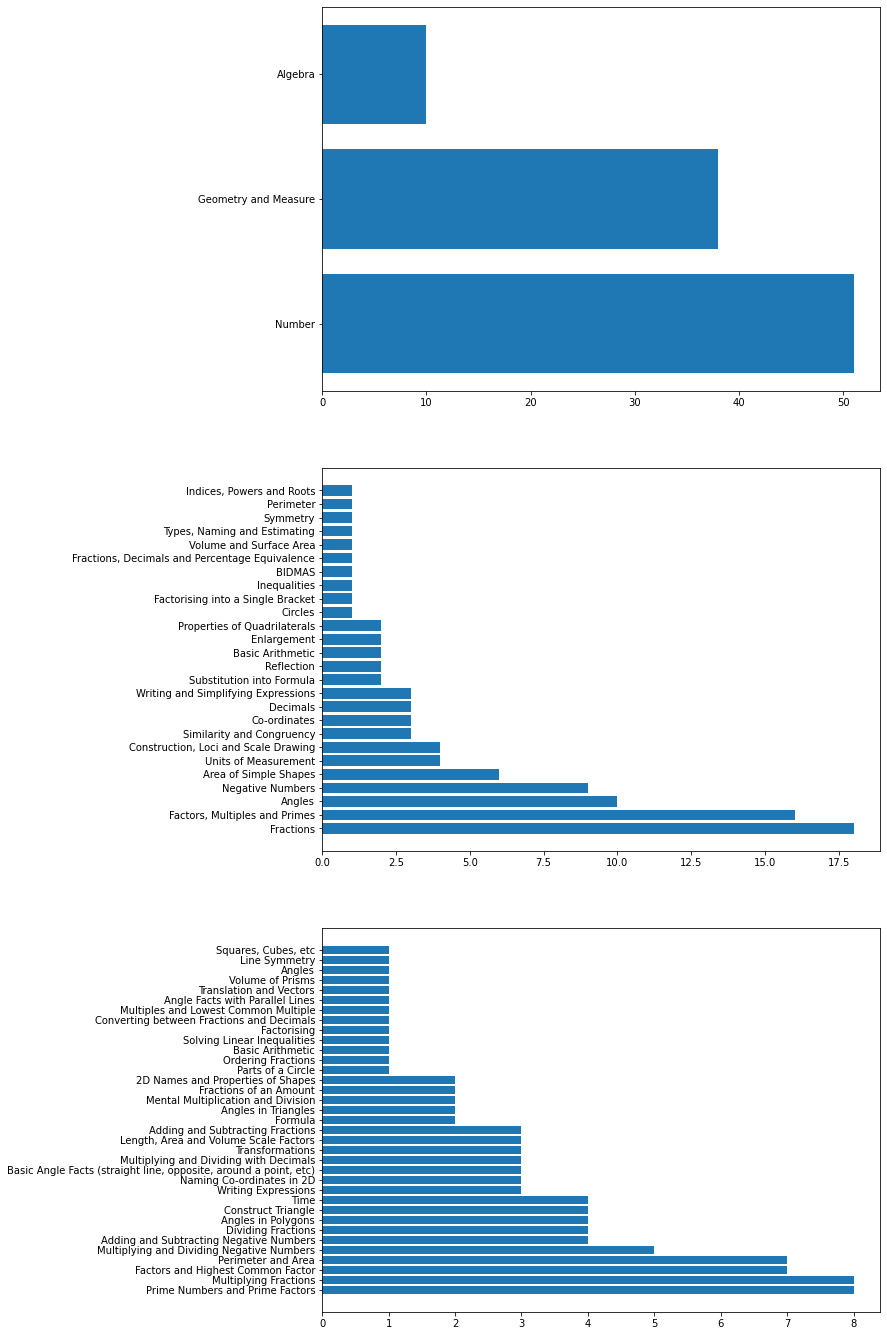

In [57]:
fig, (ax_level_1, ax_level_2, ax_level_3) = plt.subplots(3, 1, figsize = (10, 24))

ax_level_1.barh(level1.value_counts().index, level1.value_counts().values)
ax_level_2.barh(level2.value_counts().index, level2.value_counts().values)
ax_level_3.barh(level3.value_counts().index, level3.value_counts().values)

Text(0.5, 1.0, 'Question with 86% overconfident responses')

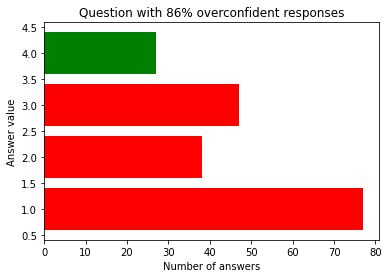

In [58]:
mostOverConfident = overconfidentQuestions.index.max()
overconfidentSubjects.loc[overconfidentQuestions.index.max()]
worstQuestion = task_3_4[task_3_4['QuestionId'] == mostOverConfident]
sortedf = worstQuestion.sort_values(by = 'AnswerValue')
plt.barh(sortedf['AnswerValue'].value_counts().index, sortedf['AnswerValue'].value_counts(), color = ["red", "red", "red", "green"])
plt.xlabel("Number of answers")
plt.ylabel("Answer value")
plt.title("Question with 86% overconfident responses")

/tmp/ipykernel_33/3610659961.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ratiosunderconfident = pd.Series()


16361


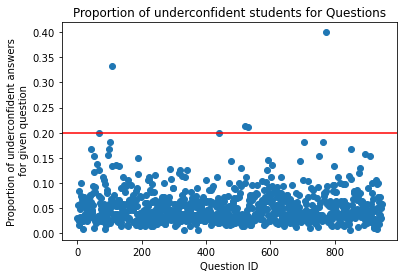

In [59]:
underconfident = overconfident_underconfident[(overconfident_underconfident['Confidence'] <= 25) & (overconfident_underconfident['IsCorrect'] == 1)]
counts = underconfident['QuestionId'].value_counts()
ratiosunderconfident = pd.Series()
threshold = 0.2
for i in counts.index:
    ratiosunderconfident.at[i] = counts[i] / overconfident_underconfident['QuestionId'].value_counts()[i]
ratiosunderconfident.sort_values(ascending = False, inplace = True)
plt.scatter(ratiosunderconfident.index, ratiosunderconfident.values)
plt.axhline(threshold, color='red')
plt.title("Proportion of underconfident students for Questions")
plt.xlabel("Question ID")
plt.ylabel("Proportion of underconfident answers\n for given question")
underconfidentcount = len(underconfident)
print(underconfidentcount)

In [61]:
ageatquestions = pd.merge(task_3_4, answer_metadata_task_3_4, on = 'AnswerId')
ageatquestions = pd.merge(ageatquestions, student_metadata_task_3_4, on = 'UserId')
ageatquestions.dropna(subset = ['DateOfBirth', 'Confidence'], inplace = True)
ageatquestions.drop(['IsCorrect', 'CorrectAnswer', 'AnswerValue', 'GroupId', 'QuizId', 'SchemeOfWorkId','QuestionId', 'AnswerId'],axis = 1, inplace = True)
ageatquestions['AgeAtQuestion'] = ageatquestions.apply(lambda row: datetime.strptime(row.DateAnswered, '%Y-%m-%d %H:%M:%S.%f') - datetime.strptime(row.DateOfBirth, '%Y-%m-%d %H:%M:%S.%f'), axis = 1)
ageatquestions = ageatquestions.groupby(['AgeAtQuestion'], as_index = False)['Confidence'].mean()